# DA Project 3


---
**Team members:**

- Sofya Aksenyuk, 150284
- Uladzimir Ivashka, 150281

---

In [1]:
# !pip install torchmetrics
# !pip install dalex

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from functools import partial
import torch
from torchmetrics.functional.classification import accuracy, f1_score as f1
from torchmetrics.functional import auroc
from pprint import pprint
import dalex as dx

2023-05-09 14:24:28.814886: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 14:24:29.489365: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda-11.7/include:/usr/lib/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:
2023-05-09 14:24:29.489447: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda-11.7/include:/usr/lib/cuda-11.7/lib6

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Dataset

In [4]:
df = pd.read_csv('Dataset.csv', sep=',', names=['variance', 'skewness', 'curtosis', 'entropy', 'class'])

In [5]:
df

variance  skewness  curtosis  entropy  class
0      3.62160   8.66610   -2.8073 -0.44699      0
1      4.54590   8.16740   -2.4586 -1.46210      0
2      3.86600  -2.63830    1.9242  0.10645      0
3      3.45660   9.52280   -4.0112 -3.59440      0
4      0.32924  -4.45520    4.5718 -0.98880      0
...        ...       ...       ...      ...    ...
1367   0.40614   1.34920   -1.4501 -0.55949      1
1368  -1.38870  -4.87730    6.4774  0.34179      1
1369  -3.75030 -13.45860   17.5932 -2.77710      1
1370  -3.56370  -8.38270   12.3930 -1.28230      1
1371  -2.54190  -0.65804    2.6842  1.19520      1

[1372 rows x 5 columns]

In [6]:
df.describe().T

count      mean       std      min       25%      50%       75%  \
variance  1372.0  0.433735  2.842763  -7.0421 -1.773000  0.49618  2.821475   
skewness  1372.0  1.922353  5.869047 -13.7731 -1.708200  2.31965  6.814625   
curtosis  1372.0  1.397627  4.310030  -5.2861 -1.574975  0.61663  3.179250   
entropy   1372.0 -1.191657  2.101013  -8.5482 -2.413450 -0.58665  0.394810   
class     1372.0  0.444606  0.497103   0.0000  0.000000  0.00000  1.000000   

              max  
variance   6.8248  
skewness  12.9516  
curtosis  17.9274  
entropy    2.4495  
class      1.0000

### Dataset description

Data was extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.

**Number of instances:** 1372

**Number of criterions:** 4

### Criteria description

- variance of Wavelet Transformed image (continuous)
- skewness of Wavelet Transformed image (continuous)
- curtosis of Wavelet Transformed image (continuous)
- entropy of image (continuous)
- class (binary):

    - genuine banknote: 0
    - forged banknote: 1

## Training Models

### XGBoost

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('class', axis=1).values, df['class'].values, test_size=0.2, stratify=df['class'], shuffle=True, random_state=1234)

In [8]:
bst = XGBClassifier(n_estimators=50, max_depth=3, random_state=1234)

evalset = [(X_train, y_train), (X_test,y_test)]

bst.fit(X_train, y_train, eval_set=evalset, verbose=0)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1234, ...)

In [9]:
preds = bst.predict(X_test)
print(f'Accuracy: {round(accuracy_score(preds, y_test), 4)}')
print(f'F1-score: {round(f1_score(preds, y_test), 4)}')
print(f'AUC-score: {round(roc_auc_score(preds, y_test), 4)}')

Accuracy: 0.9927
F1-score: 0.9919
AUC-score: 0.9919


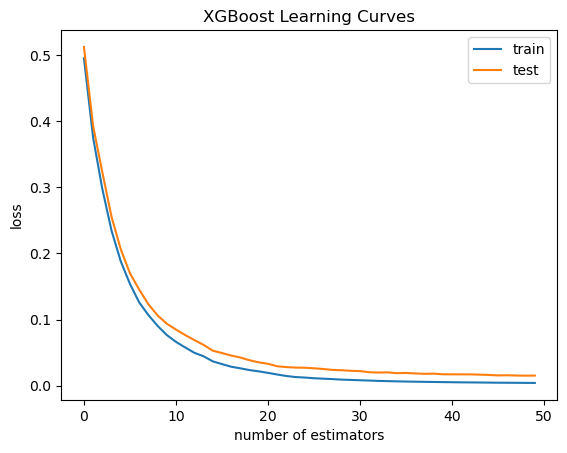

In [10]:
results = bst.evals_result()
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
plt.title('XGBoost Learning Curves')
plt.xlabel('number of estimators')
plt.ylabel('loss')
plt.legend()
plt.show();

### ANN-ChoquetIntegral

In [11]:
class NumpyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.Tensor(data)
        self.targets = torch.LongTensor(targets.astype(int))

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y

    def __len__(self):
        return len(self.data)


def Regret(x, target):
    return torch.mean(
        torch.relu(-(target >= 1).float() * x) + torch.relu((target < 1).float() * x)
    )


def Accuracy(x, target):
    return (target == (x[:, 0] > 0) * 1).detach().numpy().mean()


def AUC(x, target):
    return roc_auc_score(target.detach().numpy(), x.detach().numpy()[:, 0])


def CreateDataLoader(X, y, batch_size=None):
    if not batch_size:
      batch_size = len(X)
    dataset = NumpyDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size)


def Train(model, train_dataloader, test_dataloader, lr=0.01, epoch_nr=100):
    optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.99))
    best_acc = 0.0
    best_auc = 0.0
    val_losses = []
    train_losses = []

    for epoch in tqdm(range(epoch_nr)):
        for _, data in enumerate(train_dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = Regret(outputs, labels)
            loss.backward()
            optimizer.step()
            acc = Accuracy(outputs, labels)
            auc = AUC(outputs, labels)
        train_losses.append(loss.detach().numpy())

        with torch.no_grad():
            for i, data in enumerate(test_dataloader, 0):
                inputs, labels = data
                outputs = model(inputs)
                loss_test = Regret(outputs, labels)
                acc_test = Accuracy(outputs, labels)
                auc_test = AUC(outputs, labels)

        val_losses.append(loss_test.detach().numpy())

    return best_acc, acc_test, best_auc, auc_test, val_losses, train_losses

In [12]:
class LinearGreaterThanZero(nn.Linear):
    def __init__(self, in_features, bias=False, min_w=0.0000001):
        super().__init__(in_features, 1, bias)
        self.is_bias = bias
        self.min_w = min_w
        if bias:
            nn.init.uniform_(self.bias, self.min_w, 1.0)
        else:
            self.bias = None

    def reset_parameters(self):
        nn.init.uniform_(self.weight, 0.1, 1.0)

    def w(self):
        with torch.no_grad():
            self.weight.data[self.weight.data < 0] = self.min_w
        return self.weight

    def forward(self, input):
        return F.linear(input, self.w(), self.bias)



class LinearInteraction(nn.Linear):
    def __init__(self, in_features, criterion_layer):
        super().__init__(((in_features - 1) * in_features) // 2, 1, False)
        self.in_features = in_features
        self.criterion_layer = criterion_layer

    def reset_parameters(self):
        nn.init.normal_(self.weight, 0.0, 0.1)

    def w(self):
        with torch.no_grad():
            w_i = 0
            w = self.criterion_layer.w()
            for i in range(self.in_features):
                for j in range(i + 1, self.in_features):
                    self.weight.data[:, w_i] = torch.max(
                        self.weight.data[:, w_i], -w[:, i]
                    )
                    self.weight.data[:, w_i] = torch.max(
                        self.weight.data[:, w_i], -w[:, j]
                    )
                    w_i += 1
        return self.weight

    def forward(self, input):
        return F.linear(input, self.w(), None)



class ThresholdLayer(nn.Module):
    def __init__(self, threshold=None, requires_grad=True):
        super().__init__()
        if threshold is None:
            self.threshold = nn.Parameter(
                torch.FloatTensor(1).uniform_(0.1, 0.5), requires_grad=requires_grad
            )
        else:
            self.threshold = nn.Parameter(
                torch.FloatTensor([threshold]), requires_grad=requires_grad
            )

    def forward(self, x):
        return x - self.threshold



class ChoquetConstrained(nn.Module):
    def __init__(self, criteria_nr, **kwargs):
        super().__init__()
        self.criteria_nr = criteria_nr
        self.criteria_layer = LinearGreaterThanZero(criteria_nr)
        self.interaction_layer = LinearInteraction(criteria_nr, self.criteria_layer)
        self.thresholdLayer = ThresholdLayer()

    def forward(self, x):
        if len(x.shape) == 3:
            x = x[:, 0, :]
        x_wi = self.criteria_layer(x[:, : self.criteria_nr])
        x_wij = self.interaction_layer(x[:, self.criteria_nr :])
        weight_sum = self.criteria_layer.w().sum() + self.interaction_layer.w().sum()
        score = (x_wi + x_wij) / (weight_sum)
        return self.thresholdLayer(score)


def mobious_transform(row):
    return list(row) + [
        min(row[i], row[j]) for i in range(len(row)) for j in range(i + 1, len(row))
    ]

In [13]:
criteria_nr = 4

data_input = df.iloc[:, :criteria_nr].apply(
    lambda x: mobious_transform(x), axis=1, result_type="expand"
)

data_target = df['class'].copy()

X_train, X_test, y_train, y_test = train_test_split(data_input.values, data_target.values, test_size=0.2, stratify=data_target, shuffle=True, random_state=1234)

In [14]:
train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)

choquet = ChoquetConstrained(criteria_nr)

In [15]:
acc, acc_test, auc, auc_test, val_losses, train_losses = Train(choquet, train_dataloader, test_dataloader)

choquet.eval()
preds = choquet(torch.Tensor(X_test)).squeeze(1).detach().numpy()
preds = np.where(preds < 0, 1., 0.)

print(f'\nAccuracy: {round(accuracy_score(preds, y_test), 4)}')
print(f'F1-score: {round(f1_score(preds, y_test), 4)}')
print(f'AUC-score: {round(roc_auc_score(preds, y_test), 4)}')

100%|████████████████████████████████████████████| 100/100 [00:01<00:00, 50.01it/s]



Accuracy: 0.7273
F1-score: 0.7253
AUC-score: 0.7351


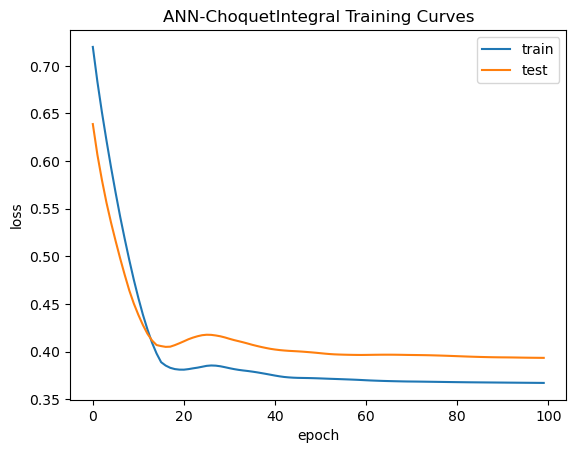

In [16]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='test')
plt.title('ANN-ChoquetIntegral Training Curves')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend();

### MyModel

In [17]:
class MyModel(nn.Module):

  def __init__(self, in_features, out_features):
    super().__init__()
    self.in_features = in_features
    self.out_features = out_features

    self.linear1 = nn.Linear(in_features, 64)
    self.linear2 = nn.Linear(64, 128)
    self.classifier = nn.Linear(128, out_features)
    self.drop_layer = nn.Dropout(p=0.15)

  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = self.drop_layer(x)
    x = F.relu(self.linear2(x))
    x = self.drop_layer(x)
    x = self.classifier(x)
    return x

  ## For Dalex explainer
  def predict(self, x):
    x = torch.Tensor(x.values).to(device)
    x = self.forward(x)
    x = F.softmax(x, dim=1)
    x = torch.argmax(x, dim=1).cpu().detach().numpy()
    return x

In [18]:
def get_metrics(pred, label):
  roc_auc_score = auroc(pred, label, task='multiclass', num_classes=2).to(device)
  pred = torch.argmax(pred, dim=1)
  acc_score = accuracy(pred, label, task='multiclass', num_classes=2).to(device)
  f1_score = f1(pred, label, task='multiclass', num_classes=2).to(device)

  return torch.Tensor([acc_score, f1_score, roc_auc_score])


def train_step(model, loader, optimizer, loss_func):
  train_total_loss = 0
  for batch_idx, (data, labels) in enumerate(loader):
    data = data.to(device)
    labels = labels.to(device)

    pred = model(data).to(device)

    loss = loss_func(pred, labels)

    train_total_loss += loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return train_total_loss / (batch_idx+1)


def val_step(model, loader, loss_func):
  val_total_loss = 0
  val_total_metrics = torch.Tensor([0, 0, 0])
  model.eval()

  with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(loader):
      data = data.to(device)
      labels = labels.to(device)

      pred = model(data).to(device)

      loss = loss_func(pred, labels)
      val_total_loss += loss

      pred = F.softmax(pred, dim=1)
      val_total_metrics += get_metrics(pred, labels)

  model.train()
  val_total_loss = val_total_loss / (batch_idx+1)
  val_total_metrics = val_total_metrics / (batch_idx+1)

  return {
              'val_loss': val_total_loss,
              'acc': val_total_metrics[0],
              'f1': val_total_metrics[1],
              'roc': val_total_metrics[2]
          } 


def my_train(model, train_loader, test_loader, lr=0.0001, epoch=40):
  optimizer = optim.Adam(params=model.parameters(), lr=lr)
  loss_func = nn.CrossEntropyLoss()
  train_losses = []
  val_losses = []

  for epoch in range(epoch):
    train_loss = train_step(model, train_loader, optimizer, loss_func)
    print(f'==> Epoch {epoch}: train loss = {train_loss}')
    train_losses.append(train_loss.detach().cpu().numpy())

    val_stat = val_step(model, test_loader, loss_func)
    print(f'\tValidation: Loss = {round(val_stat["val_loss"].item(), 5)}, Accuracy = {round(val_stat["acc"].item(),5)},',
            f'F1 = {round(val_stat["f1"].item(), 5)}, ROC-AUC = {round(val_stat["roc"].item(), 5)}')
    val_losses.append(val_stat["val_loss"].item())

  return train_losses, val_losses

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('class', axis=1).values, df['class'].values, test_size=0.2, stratify=df['class'], shuffle=True, random_state=1234)

train_dataloader = CreateDataLoader(X_train, y_train, batch_size=128)
test_dataloader = CreateDataLoader(X_test, y_test, batch_size=128)

In [20]:
net = MyModel(4, 2).to(device)

In [21]:
net

MyModel(
  (linear1): Linear(in_features=4, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=128, bias=True)
  (classifier): Linear(in_features=128, out_features=2, bias=True)
  (drop_layer): Dropout(p=0.15, inplace=False)
)

In [22]:
train_losses, val_losses = my_train(net, train_dataloader, test_dataloader)

==> Epoch 0: train loss = 0.8280320763587952
	Validation: Loss = 0.75865, Accuracy = 0.39693, F1 = 0.39693, ROC-AUC = 0.56417
==> Epoch 1: train loss = 0.7409314513206482
	Validation: Loss = 0.68429, Accuracy = 0.5381, F1 = 0.5381, ROC-AUC = 0.75122
==> Epoch 2: train loss = 0.6734253764152527
	Validation: Loss = 0.62636, Accuracy = 0.80743, F1 = 0.80743, ROC-AUC = 0.85285
==> Epoch 3: train loss = 0.6193217635154724
	Validation: Loss = 0.58141, Accuracy = 0.85101, F1 = 0.85101, ROC-AUC = 0.88571
==> Epoch 4: train loss = 0.5697414875030518
	Validation: Loss = 0.54662, Accuracy = 0.85293, F1 = 0.85293, ROC-AUC = 0.89101
==> Epoch 5: train loss = 0.5366079211235046
	Validation: Loss = 0.51778, Accuracy = 0.85293, F1 = 0.85293, ROC-AUC = 0.90655
==> Epoch 6: train loss = 0.5024465918540955
	Validation: Loss = 0.49255, Accuracy = 0.84772, F1 = 0.84772, ROC-AUC = 0.91617
==> Epoch 7: train loss = 0.48219892382621765
	Validation: Loss = 0.46941, Accuracy = 0.87829, F1 = 0.87829, ROC-AUC = 0

In [23]:
net.eval()
pred = net(torch.Tensor(X_test).to(device))
pred = F.softmax(pred, dim=1)
pred = torch.argmax(pred, dim=1).cpu().detach().numpy()

print(f'Accuracy: {round(accuracy_score(pred, y_test), 4)}')
print(f'F1-score: {round(f1_score(pred, y_test), 4)}')
print(f'AUC-score: {round(roc_auc_score(pred, y_test), 4)}')

Accuracy: 0.9964
F1-score: 0.9959
AUC-score: 0.9959


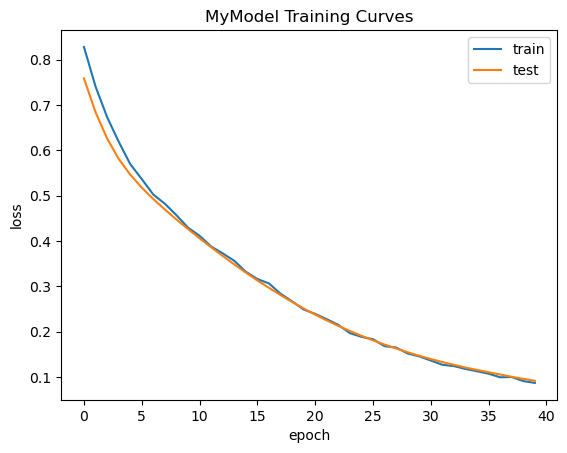

In [24]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='test')
plt.title('MyModel Training Curves')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend();

#### Observations

XGBoost Classifier and MyModel perform nearly the same well. Whereas ANN-ChoquetIntegral shows worse metric results, as well as the Training Curves plot of it depicts the problem of learning for the model - the train and test curves' tendencies may correspond to the model being underfitted. Apart from that, ANN-ChoquetIntegral Model is much more computationally expensive than the other ones. The Mobious transformation applied to the input data makes the model interpretation a more unique case when it comes to ANN-ChoquetIntegral. That is why DALEX Explainer was not used for it.

## Space sampling - Finding breakpoints (preference thresholds)

In [25]:
def find_breakpoints(model, sample, df, model_type):

  def get_sample_pred(model, sample, model_type):
    if model_type == 'XGBoost':
      pred = model.predict([sample])[0]
    else:
      if model_type == 'ANN-ChoquetIntegral':
        sample = torch.Tensor(mobious_transform(sample)).unsqueeze(0)
      else:
        sample = torch.Tensor(sample).to(device)
      model.eval()
      with torch.no_grad():
        pred = model(sample)
        pred = F.softmax(pred, dim=0)
        pred = torch.argmax(pred).cpu().detach().item()

    return pred


  feature_description = df.describe().T
  res = {}
  breakpoints = {}

  for idx, feature in enumerate(df.columns.drop('class')):
    breakpoints[feature] = np.nan
    min_ = feature_description.loc[feature, 'min']
    max_ = feature_description.loc[feature, 'max']
    space = np.linspace(min_, max_, 100)
    real_pt = sample[idx]

    preds = {}
    previous = get_sample_pred(model, sample, model_type)
    for pt in space:
      sample[idx] = pt
      pred = get_sample_pred(model, sample, model_type)
      preds[pt] = pred
      if pred != previous:
        previous = pred
        breakpoints[feature] = pt

    res[feature] = preds
    sample[idx] = real_pt

  return res, breakpoints

[•] Sample 0 - Model: XGBoost
Sample 0: [ 0.76163  5.8209   1.1959  -0.64613]
[•] Breakpoints: {'variance': -2.4198000000000004, 'skewness': nan, 'curtosis': nan, 'entropy': nan}
Minimal changes: [3.18143     nan     nan     nan]



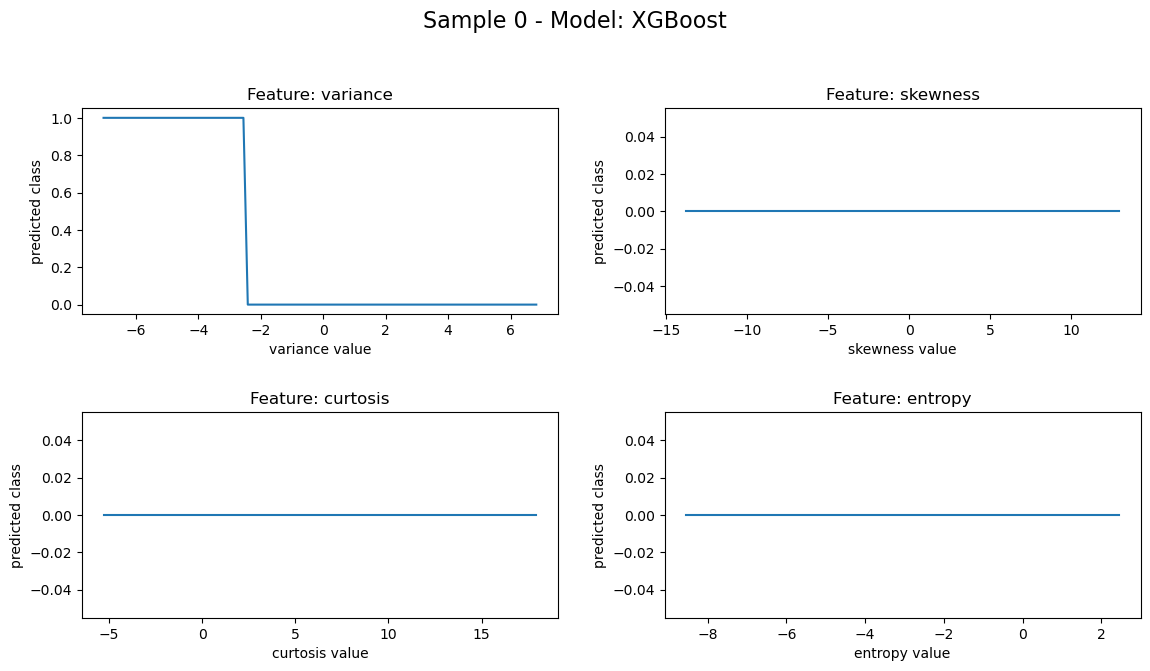


[•] Sample 0 - Model: Neural Network with non-linear activations
Sample 0: [ 0.76163  5.8209   1.1959  -0.64613]
[•] Breakpoints: {'variance': -3.4002878787878785, 'skewness': -3.515134343434342, 'curtosis': -3.410261616161616, 'entropy': nan}
Minimal changes: [4.16191788 9.33603434 4.60616162        nan]



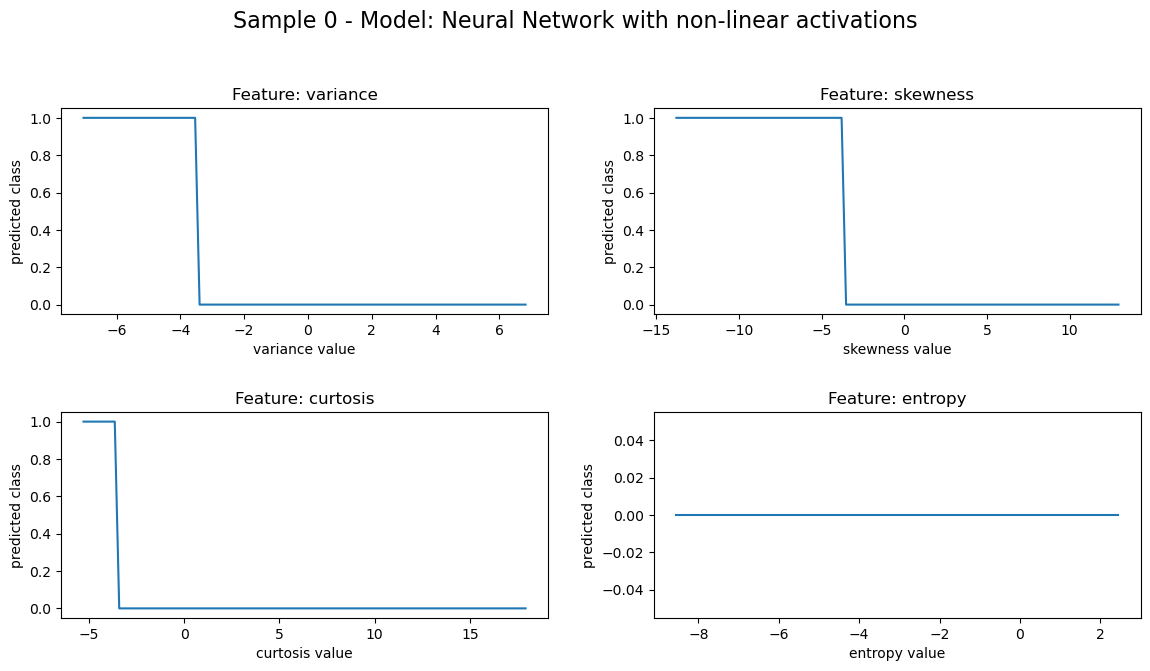


[•] Sample 1 - Model: XGBoost
Sample 1: [ 0.65497  5.1815   1.0673  -0.42113]
[•] Breakpoints: {'variance': -1.2992424242424248, 'skewness': nan, 'curtosis': -1.2999434343434344, 'entropy': nan}
Minimal changes: [1.95421242        nan 2.36724343        nan]



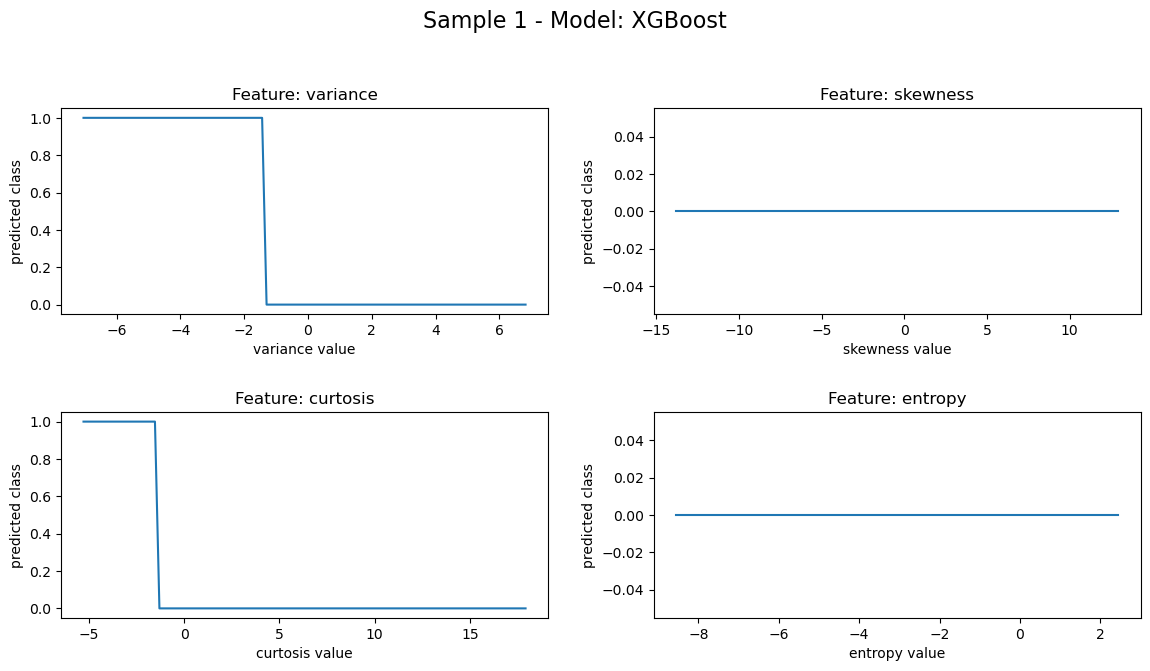


[•] Sample 1 - Model: Neural Network with non-linear activations
Sample 1: [ 0.65497  5.1815   1.0673  -0.42113]
[•] Breakpoints: {'variance': -2.9800787878787878, 'skewness': -2.7052949494949488, 'curtosis': -2.9413020202020204, 'entropy': nan}
Minimal changes: [3.63504879 7.88679495 4.00860202        nan]



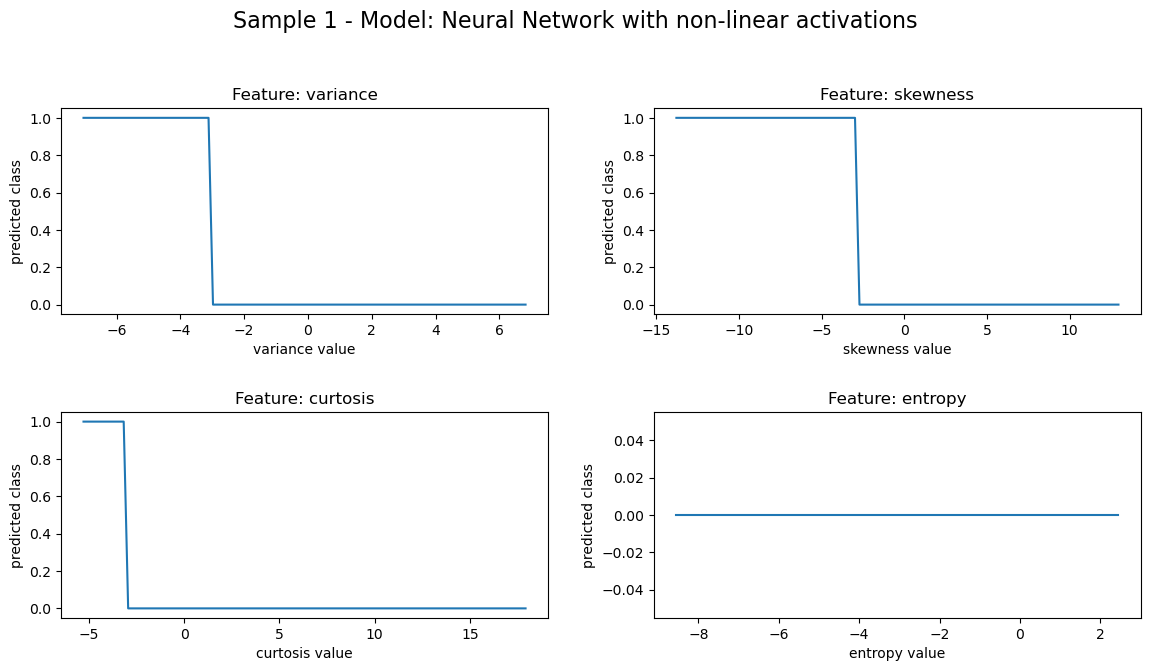


[•] Sample 2 - Model: XGBoost
Sample 2: [-0.64326  2.4748  -2.9452  -1.0276 ]
[•] Breakpoints: {'variance': nan, 'skewness': 5.663045454545454, 'curtosis': 1.2793343434343436, 'entropy': nan}
Minimal changes: [       nan 3.18824545 4.22453434        nan]



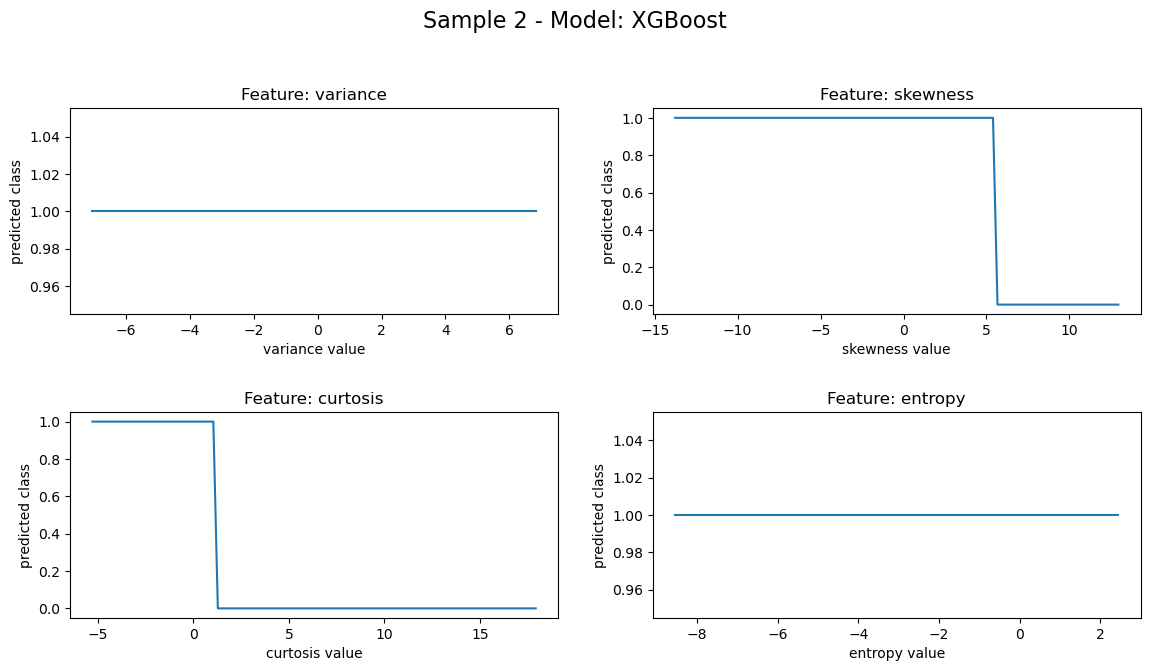


[•] Sample 2 - Model: Neural Network with non-linear activations
Sample 2: [-0.64326  2.4748  -2.9452  -1.0276 ]
[•] Breakpoints: {'variance': 2.062430303030302, 'skewness': 7.282724242424244, 'curtosis': -0.36202424242424236, 'entropy': nan}
Minimal changes: [2.7056903  4.80792424 2.58317576        nan]



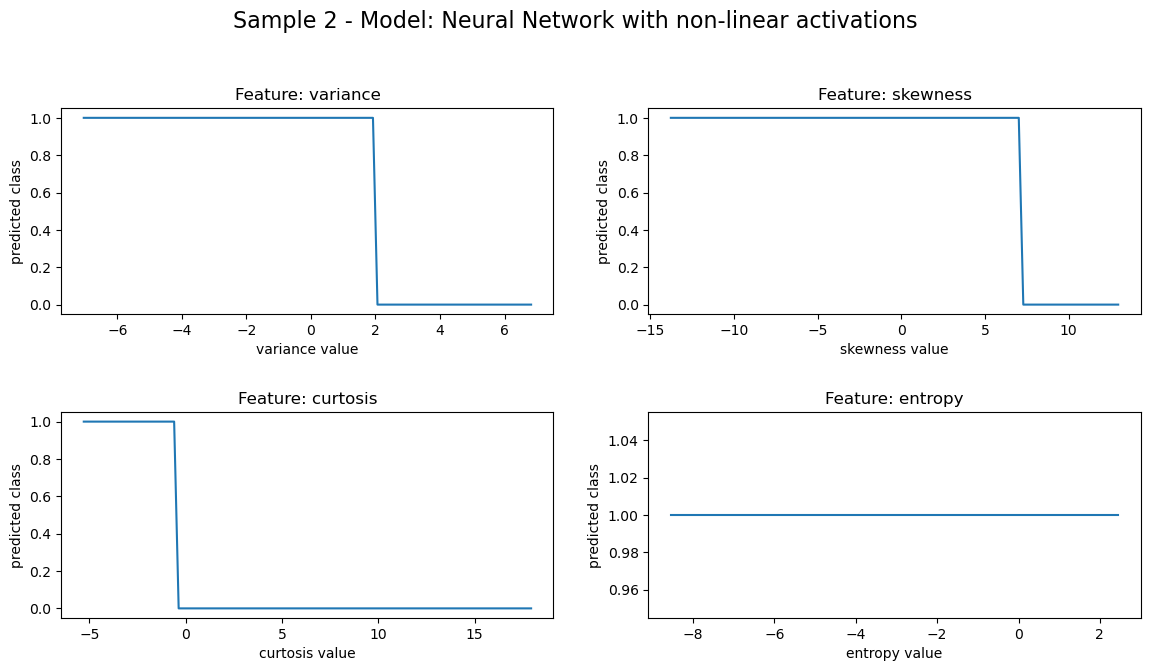

In [26]:
samples = X_test[:3].copy()
models = {'XGBoost': bst, 'Neural Network with non-linear activations': net}

for idx, sample in enumerate(samples):
  for name, model in models.items():
    spaces, breakpoints = find_breakpoints(model, sample.copy(), df, model_type=name)
    print(f"[•] Sample {idx} - Model: {name}")
    print(f'Sample {idx}: {sample}')
    print('[•] Breakpoints:', breakpoints)
    print("Minimal changes:", abs(sample - np.array(list(breakpoints.values()))))
    print()

    fig, ax = plt.subplots(2, 2, figsize=(12, 7))
    ax = ax.ravel()
    for plot_idx, (feature, space) in enumerate(spaces.items()):
      ax[plot_idx].plot(space.keys(), space.values())
      ax[plot_idx].set_title(f'Feature: {feature}')
      ax[plot_idx].set_xlabel(f'{feature} value')
      ax[plot_idx].set_ylabel('predicted class')
    fig.suptitle(f'Sample {idx} - Model: {name}', fontsize=16)
    fig.tight_layout(pad=2.5)
    plt.show()
    print()

#### Observations

For Sample 0 the breakpoints found by XGBoost and MyModel differ completely: for XGBoost change in only variance feature value may lead to another classification decision, whereas in case of MyModel - only entropy feature does not play any role.

For Sample 1 the picture is absolutely different: for XGBoost everything but skewness feature has a breakpoint of when an alternative becomes classified as another class, and as for MyModel the same situation appears for entropy feature.

For Sample 2 both methods agreed on feature importance: everything but entropy may impact the decision class. Besides, even the breakpoints for the rest of the features are of nearly the same values.

Generally, in case of these three samples, entropy feature makes the least impact on the classifier's decision, whereas variance - the biggest one, it also needs the smallest of all minimal changes to be classified as a different class. 

**Note:** In our case, minimal change was obtained by computing the distance between the original values of a samples' feature to the breakpoint found.

## Prediction explanation using SHAP

In [27]:
## Preprocessing for DALEX Explainer
X_test_df = pd.DataFrame(X_test, columns=df.columns.drop('class'))
y_test_df = pd.DataFrame(y_test, columns=['class'])

In [28]:
bst_exp = dx.Explainer(bst, X_test_df,  y_test_df)

Preparation of a new explainer is initiated

  -> data              : 275 rows 4 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 275 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7f5ad35c1d30> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 3.01e-05, mean = 0.449, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.705, mean = -0.00549, max = 0.0924
  -> model_info        : package xgboost

A new explainer has been created!


==> XGBoost
Sample 1:


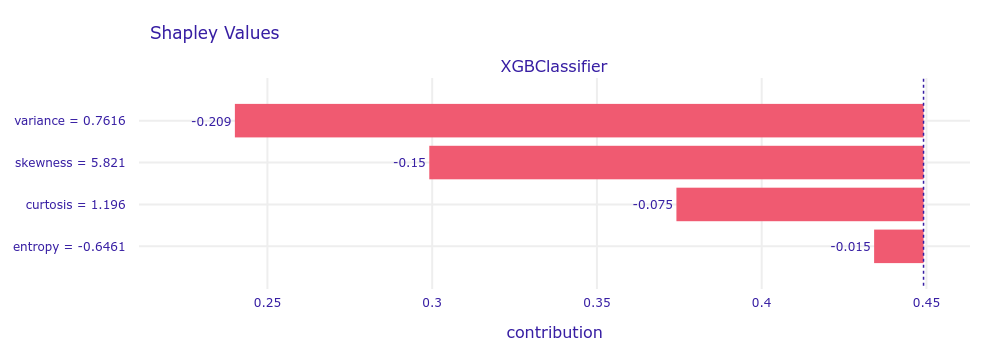

Sample 2:


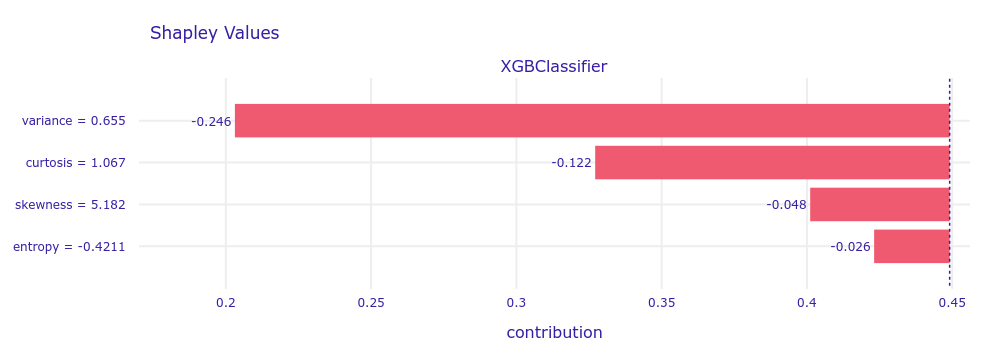

Sample 3:


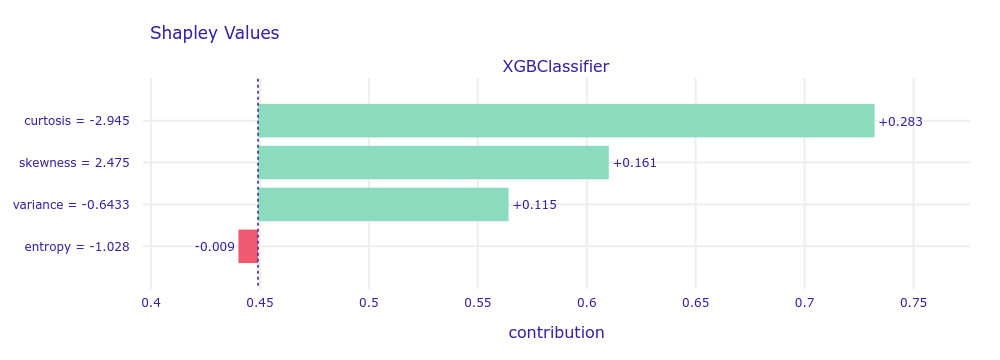

In [29]:
print('==> XGBoost')
print('Sample 1:')
bst_exp.predict_parts(samples[0], type='shap').plot()
print('Sample 2:')
bst_exp.predict_parts(samples[1], type='shap').plot()
print('Sample 3:')
bst_exp.predict_parts(samples[2], type='shap').plot()

In [30]:
net_exp = dx.Explainer(net, X_test_df,  y_test_df)

Preparation of a new explainer is initiated

  -> data              : 275 rows 4 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 275 values
  -> model_class       : __main__.MyModel (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7f5ad35c1ca0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.447, max = 1.0
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = -0.00364, max = 0.0
  -> model_info        : package __main__

A new explainer has been created!


==> MyModel
Sample 1:


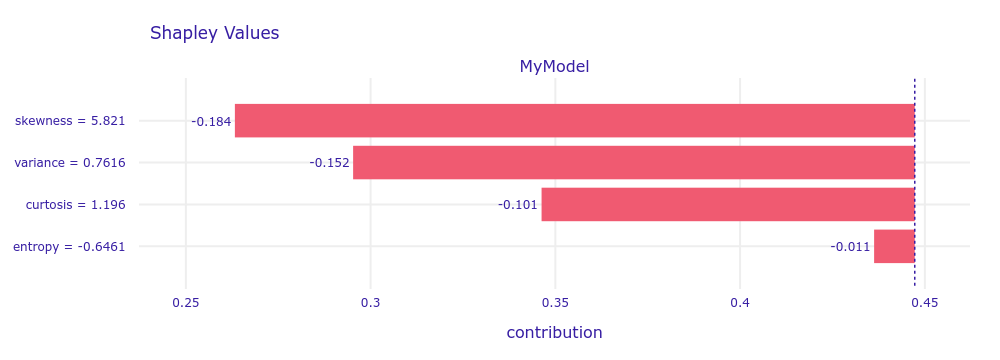

Sample 2:


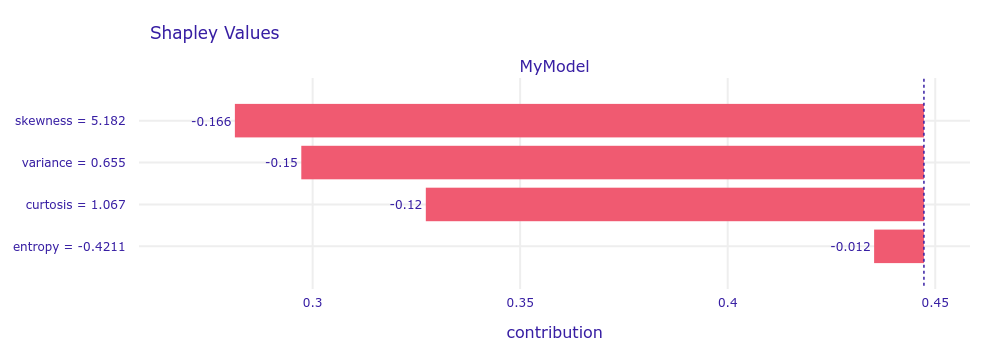

Sample 3:


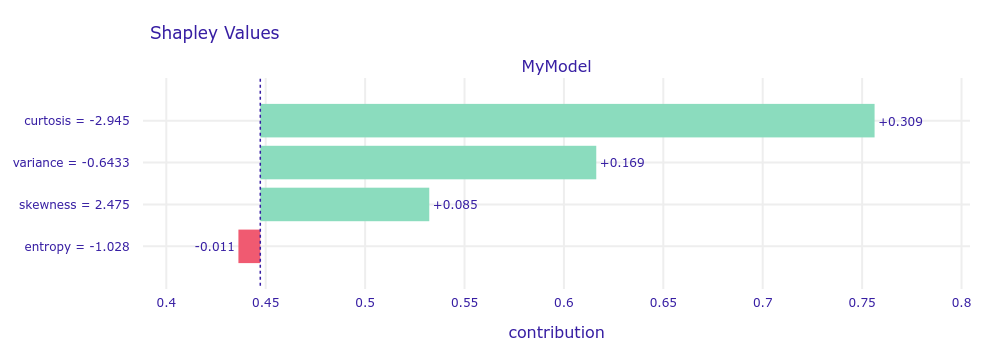

In [31]:
print('==> MyModel')
print('Sample 1:')
net_exp.predict_parts(samples[0], type='shap').plot()
print('Sample 2:')
net_exp.predict_parts(samples[1], type='shap').plot()
print('Sample 3:')
net_exp.predict_parts(samples[2], type='shap').plot()

#### Observations

The obtained Shapley Values confirm that the entropy feature mainly has the least decisive influence for both models, whereas variance always takes one of the highest importance places: the most important or second most important feature.

## Model interpretation

==> XGBoost
Feature importance:


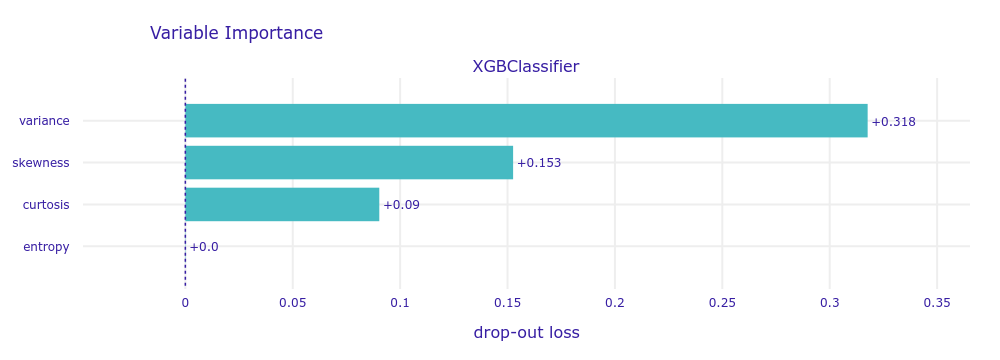


Partial dependency for whole dataset:


Calculating ceteris paribus: 100%|██████████████████| 4/4 [00:00<00:00, 152.04it/s]


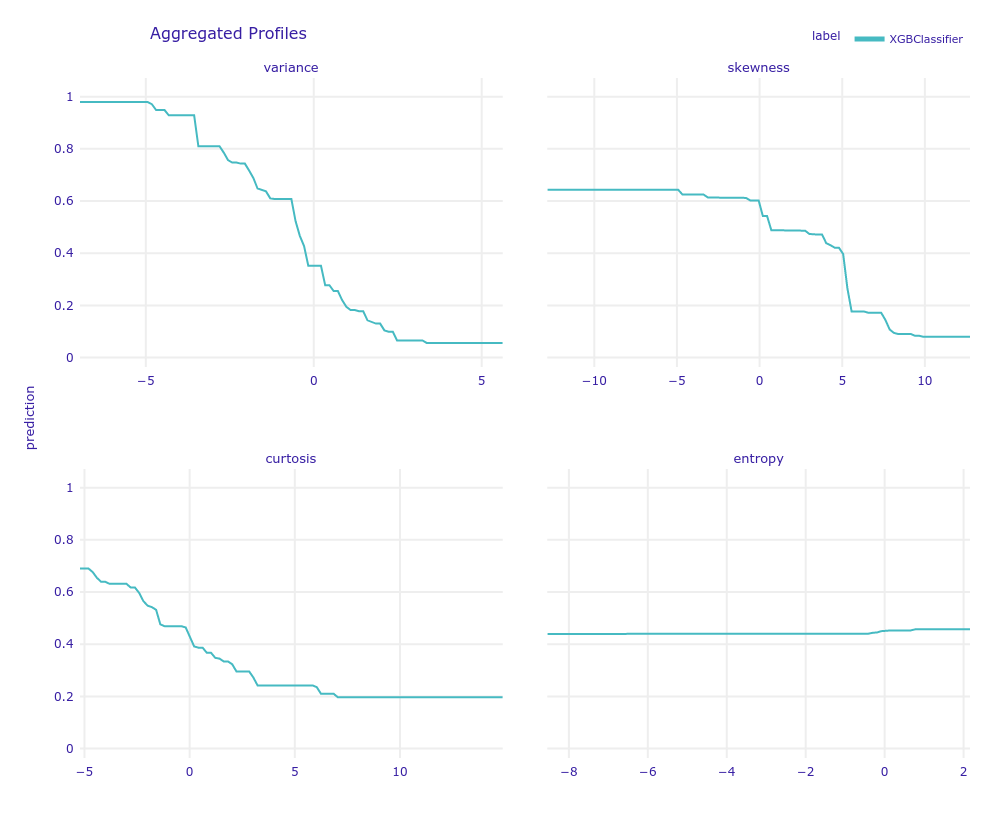

In [32]:
print('==> XGBoost')
print('Feature importance:')
bst_exp.model_parts().plot()
print('\nPartial dependency for whole dataset:')
bst_exp.model_profile().plot()

==> MyModel
Feature importance:


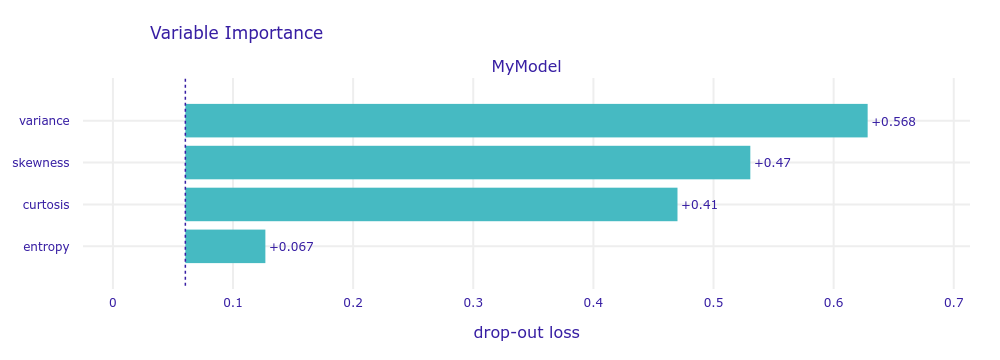


Partial dependency for whole dataset:


Calculating ceteris paribus: 100%|██████████████████| 4/4 [00:00<00:00, 297.81it/s]


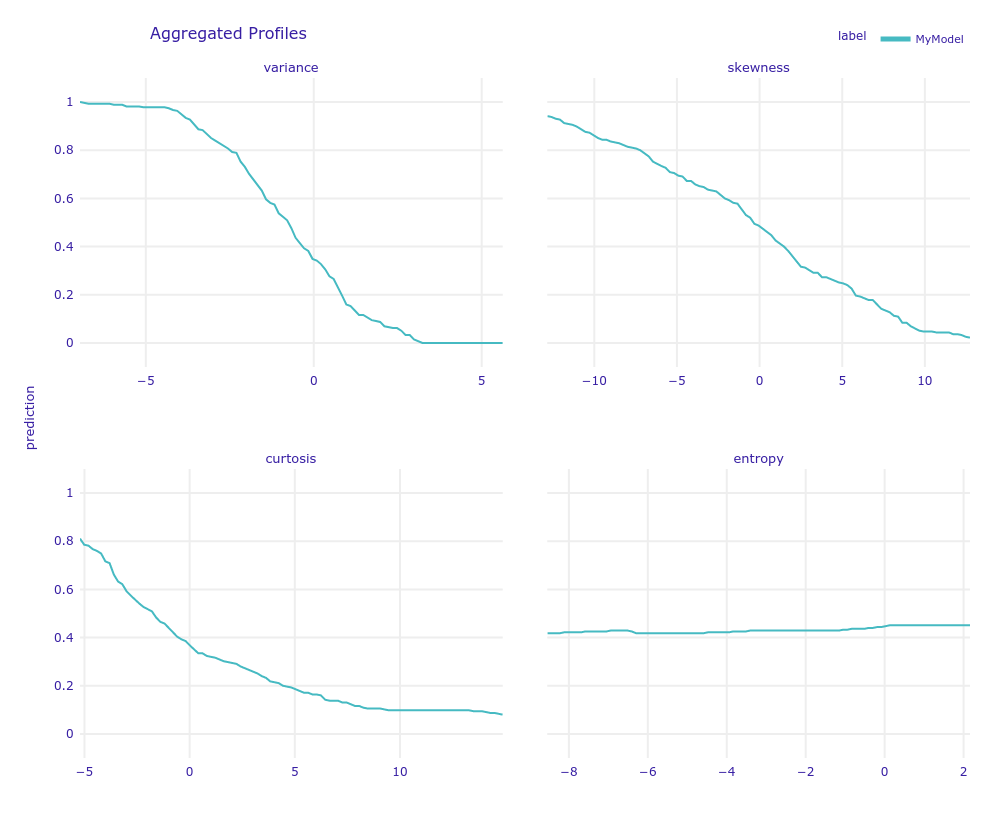

In [33]:
print('==> MyModel')
print('Feature importance:')
net_exp.model_parts().plot()
print('\nPartial dependency for whole dataset:')
net_exp.model_profile().plot()

In [34]:
weights = choquet.criteria_layer.w().detach().numpy()[0]
interaction_weights = choquet.interaction_layer.w().detach().numpy()[0]
s = weights.sum() + interaction_weights.sum()
weights = weights / s
interaction_weights = interaction_weights / s

interactions = np.zeros((criteria_nr, criteria_nr))
weight_id = 0
for i in range(criteria_nr):
    for j in range(i + 1, criteria_nr):
        interactions[i, j] = interactions[j, i] = interaction_weights[weight_id]
        weight_id += 1

print("Criteria weights:")
print(weights)
print()
print("Criteria interactions:")
print(interactions)
print()

shapley = weights + interactions.sum(0) / 2
print("Importance of criterina (Shapley value):")
print(shapley)

print(f'\nWeights used:\n{weights}')

Criteria weights:
[5.0028905e-08 3.0993161e-01 2.3676343e-01 4.9682769e-01]

Criteria interactions:
[[ 0.00000000e+00 -5.00289055e-08  5.49143888e-02 -5.00289055e-08]
 [-5.00289055e-08  0.00000000e+00 -9.06942189e-02 -9.30688158e-02]
 [ 5.49143888e-02 -9.06942189e-02  0.00000000e+00  8.53259787e-02]
 [-5.00289055e-08 -9.30688158e-02  8.53259787e-02  0.00000000e+00]]

Importance of criterina (Shapley value):
[0.02745719 0.21805006 0.26153651 0.49295625]

Weights used:
[5.0028905e-08 3.0993161e-01 2.3676343e-01 4.9682769e-01]


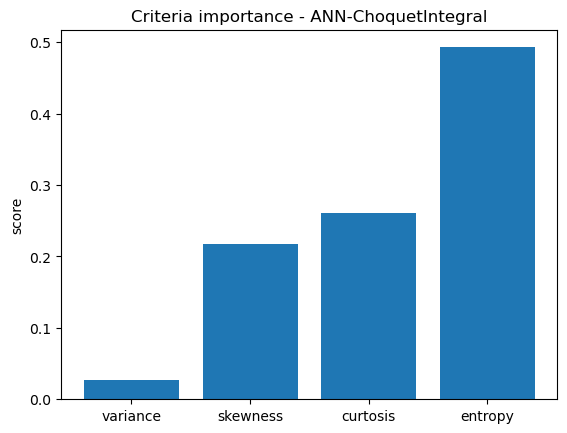

In [35]:
plt.bar(df.columns.drop('class'), shapley)
plt.title('Criteria importance - ANN-ChoquetIntegral')
plt.ylabel('score');

#### Observations

As it can be seen, the weight (and, therefore, importance) distribution of ANN-ChoquetIntegral fully contradicts the ones obtained by the other models. For example, variance was found the least important by ANN-ChoquetIntegral and entropy - the most, whereas the situation is the opposite for the other methods. Perhaps, that could be the cause of such a low resulting performance of ANN-ChoquetIntegral in our case.

When it comes to Partial Dependencies, the picture is as follows:

- XGBoost: variance > curtosis ~ skewness > entropy 
- MyModel: varience ~ skewness > curtosis > entropy

where,
entropy has almost zero impact.

It was also noticed that MyModel Partial Dependency Curves are much smoother than the XGBoost ones.

**Note:** Partial Dependecy analysis was not performed for ANN-ChoquetIntegral due to its feature Mobious trasformation.

